In [94]:
print("hello")

hello


In [95]:
import os
import requests
from datetime import datetime, timedelta, timezone
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [96]:
exp_id = 2

raw_runs = []

filenames = [filename for filename in os.listdir('.') if filename.startswith(f"exp{exp_id}") and filename.endswith(".csv")]
for filename in filenames:
    #print(filename)
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(filename)
    input = df.loc[df['topic'] == "input"]

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()

    X = input.iloc[:, 2].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = input.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    trend_slope = linear_regressor.coef_[0][0]
    #print(linear_regressor.coef_)

    row = {'dim_value': int(dim_value), 'instances': int(instances), 'trend_slope': trend_slope}
    #print(row)
    raw_runs.append(row)

runs = pd.DataFrame(raw_runs)

In [97]:
runs.head()

,dim_value,instances,trend_slope
0,50000,16,-0.000320
1,100000,4,4.725856
2,10000,8,0.000199
3,100000,2,12453.589047
4,10000,4,-0.000035


In [98]:
threshold = 10

# Set feas to true if the trend line has a slope less than 100 ms and "enough" outputs are created
runs["suitable"] =  runs.apply(lambda row: row['trend_slope'] < 10, axis=1)

runs

,dim_value,instances,trend_slope,suitable
0,50000,16,-0.000320,True
1,100000,4,4.725856,True
2,10000,8,0.000199,True
3,100000,2,12453.589047,False
4,10000,4,-0.000035,True
5,10000,1,0.099193,True
6,50000,12,-0.000573,True
7,50000,2,-0.160000,True
8,50000,4,-0.551198,True
9,10000,16,0.000000,True


In [99]:
filtered = runs[runs.apply(lambda x: x['suitable'], axis=1)]

filtered

grouped = filtered.groupby(['dim_value'])['instances'].min()
min_suitable_instances = grouped.to_frame().reset_index()

min_suitable_instances

,dim_value,instances
0,10000,1
1,50000,2
2,100000,4


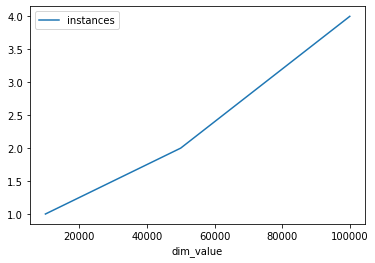

In [101]:
min_suitable_instances.plot(kind='line',x='dim_value',y='instances')

plt.show()